In [29]:
import os
import numpy as np
import pathlib
import tensorflow as tf
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [32]:
# Reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# ==== CONFIGURATION ====
DATASET_PATH = pathlib.Path('/content/drive/MyDrive/speech_commands_subset')
COMMANDS = ['up', 'down', 'left', 'right']
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
EPOCHS = 15
MAX_FILES_PER_COMMAND = 2000  # limit if dataset is huge
SAMPLE_RATE = 16000
DURATION = 1.0  # seconds

print("Configuration:")
print(f" dataset: {DATASET_PATH}")
print(f" commands: {COMMANDS}")
print(f" batch size: {BATCH_SIZE}, epochs: {EPOCHS}")

Configuration:
 dataset: /content/drive/MyDrive/speech_commands_subset
 commands: ['up', 'down', 'left', 'right']
 batch size: 32, epochs: 15


In [21]:
# ==== MOUNT GOOGLE DRIVE ====
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
try:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if 'failed' in gpu_info.lower():
        print('No GPU detected')
    else:
        print('GPU detected:')
        print(gpu_info)
except Exception:
    print('nvidia-smi not available in this environment')

GPU detected:
Wed Sep  3 01:44:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             53W /  400W |    1985MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+---------------------------------

In [34]:
# ==== DATA LOADING & SPLIT ====
def load_and_prepare_data():
    all_audio_paths = list(DATASET_PATH.glob('*/*.wav'))
    print(f"Total .wav files found: {len(all_audio_paths)}")

    command_to_files = defaultdict(list)
    for p in all_audio_paths:
        lab = p.parent.name
        if lab in COMMANDS:
            command_to_files[lab].append(p)

    train_files, val_files, test_files = [], [], []

    for command in COMMANDS:
        files = command_to_files[command]
        if len(files) == 0:
            raise ValueError(f"No files found for command: {command}")
        if len(files) > MAX_FILES_PER_COMMAND:
            files = random.sample(files, MAX_FILES_PER_COMMAND)

        random.shuffle(files)
        n = len(files)
        n_train = int(0.7 * n)
        n_val = int(0.85 * n)
        train_files.extend(files[:n_train])
        val_files.extend(files[n_train:n_val])
        test_files.extend(files[n_val:])

    print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")
    return train_files, val_files, test_files

train_files, val_files, test_files = load_and_prepare_data()


Total .wav files found: 9479
Train: 5600, Val: 1200, Test: 1200


In [35]:
# ==== AUDIO PROCESSING HELPERS ====
COMMANDS_TF = tf.constant(COMMANDS)  # for label -> id conversion in TF graph

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)
    return audio

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2]
    return label

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def preprocess_audio(waveform):
    # avoid divide-by-zero
    max_val = tf.reduce_max(tf.abs(waveform))
    waveform = tf.cond(max_val > 0, lambda: waveform / max_val, lambda: waveform)

    waveform = waveform[:SAMPLE_RATE]  # trim
    padding = tf.maximum(SAMPLE_RATE - tf.shape(waveform)[0], 0)
    waveform = tf.pad(waveform, paddings=[[0, padding]], mode='CONSTANT')
    waveform = tf.cast(waveform, tf.float32)
    return waveform

def get_spectrogram(waveform):
    stft = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(stft)
    spectrogram = tf.expand_dims(spectrogram, -1)  # add channel
    return spectrogram

def preprocess_dataset(waveform, label):
    waveform = preprocess_audio(waveform)
    spectrogram = get_spectrogram(waveform)
    # label -> id (0..len(COMMANDS)-1)
    equal = tf.equal(label, COMMANDS_TF)         # compares string to list -> bool tensor
    label_id = tf.argmax(tf.cast(equal, tf.int32))  # returns index
    label_id = tf.cast(label_id, tf.int32)
    return spectrogram, label_id

In [36]:
# ==== BUILD TF DATASETS ====
def create_dataset(file_paths, shuffle=False, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices([str(p) for p in file_paths])
    ds = ds.map(lambda p: get_waveform_and_label(p), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(preprocess_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(SHUFFLE_BUFFER_SIZE)
    ds = ds.batch(batch_size)
    ds = ds.cache().prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_files, shuffle=True, batch_size=BATCH_SIZE)
val_ds = create_dataset(val_files, shuffle=False, batch_size=BATCH_SIZE)
test_ds = create_dataset(test_files, shuffle=False, batch_size=BATCH_SIZE)

# Inspect input shape
for spec_batch, label_batch in train_ds.take(1):
    input_shape = spec_batch.shape[1:]  # exclude batch
print("Input shape (H, W, C):", input_shape)

Input shape (H, W, C): (124, 129, 1)


In [38]:
# ==== MODEL (lightweight) ====
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),

        # small conv block 1
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.2),

        # small conv block 2
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.25),

        # optional small conv block 3 (kept modest)
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.25),

        # Global pooling for compactness (avoids huge dense layer)
        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_model(input_shape, len(COMMANDS))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 124, 129, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 124, 129, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 62, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 62, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 62, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 62, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 31, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 31, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 31, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 31, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 15, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 15, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,220 (254.77 KB)

 Trainable params: 64,900 (253.52 KB)

 Non-trainable params: 320 (1.25 KB)

In [39]:
# ==== CALLBACKS ====
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

In [40]:
# ==== TRAIN ====
print("Starting training...")
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    verbose=1)

Starting training...
Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.6781 - loss: 0.8662 - val_accuracy: 0.2458 - val_loss: 1.6893 - learning_rate: 0.0010
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4485 - loss: 1.4230 - val_accuracy: 0.2458 - val_loss: 1.7225 - learning_rate: 0.0010
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5186 - loss: 1.2301 - val_accuracy: 0.3358 - val_loss: 1.5346 - learning_rate: 0.0010
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5690 - loss: 1.1746 - val_accuracy: 0.3233 - val_loss: 1.5756 - learning_rate: 0.0010
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5983 - loss: 1.1278 - val_accuracy: 0.2958 - val_loss: 1.8958 - learning_rate: 0.0010
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5862 - loss: 1.0851 - val_accuracy: 0.2550 - val_loss: 1.8071 - learning_rate: 0.0010
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.

In [41]:
# ==== EVALUATE ====
print("Evaluating on test set...")
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Evaluating on test set...
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5602 - loss: 0.7825
Test loss: 0.6216, Test accuracy: 0.7275


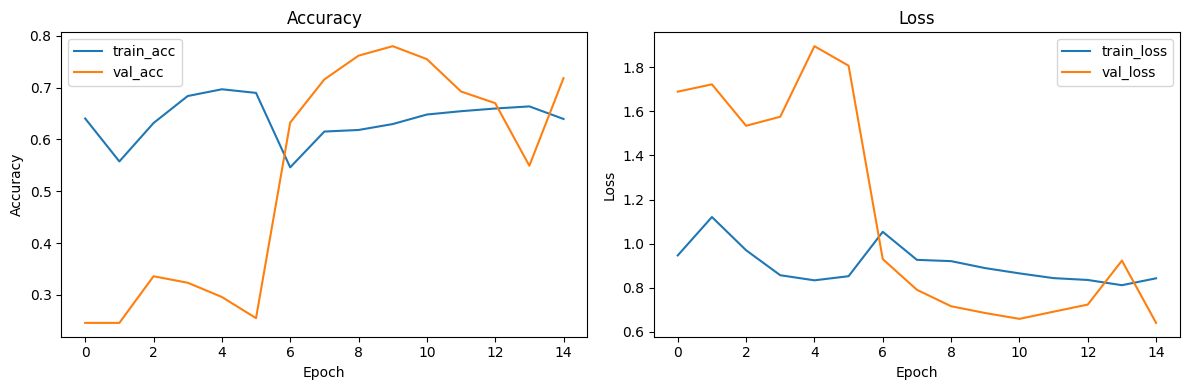

In [42]:
# ==== PLOTS ====
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout()
plt.show()

Generating confusion matrix & classification report...


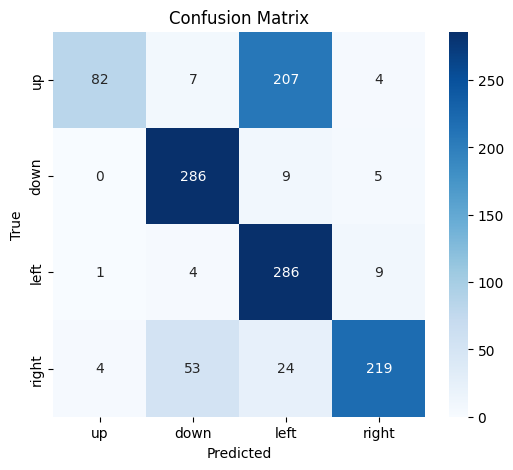

Classification report:
              precision    recall  f1-score   support

          up       0.94      0.27      0.42       300
        down       0.82      0.95      0.88       300
        left       0.54      0.95      0.69       300
       right       0.92      0.73      0.82       300

    accuracy                           0.73      1200
   macro avg       0.81      0.73      0.70      1200
weighted avg       0.81      0.73      0.70      1200



In [43]:
# ==== CONFUSION MATRIX & CLASS REPORT ====
print("Generating confusion matrix & classification report...")
y_true = []
y_pred = []

for spec_batch, labels_batch in test_ds:
    preds = model.predict(spec_batch, verbose=0)
    y_true.extend(labels_batch.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=COMMANDS, yticklabels=COMMANDS)
plt.title('Confusion Matrix')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=COMMANDS))


In [44]:
# ==== EXPORT TO TFLITE AND SAVE KERAS MODEL ====
print("Converting to TFLite (float32)...")
tflite_path = '/content/keyword_spotting.tflite'
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # default optimization (will not quantize without representative dataset)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    print("TFLite saved to:", tflite_path, f" size: {os.path.getsize(tflite_path)/1024:.1f} KB")
except Exception as e:
    print("TFLite conversion failed:", e)

keras_path = '/content/speech_command_model.h5'
model.save(keras_path)
print("Keras model saved to:", keras_path)

labels_path = '/content/class_labels.txt'
with open(labels_path, 'w') as f:
    for c in COMMANDS:
        f.write(c + '\n')
print("Class labels saved to:", labels_path)

Converting to TFLite (float32)...
Saved artifact at '/tmp/tmp0jaixbci'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='keras_tensor_80')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132517059396816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132517059399504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132517059399888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132517059400848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132517059400656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132517059400080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132517059400464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132517059399696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132517059399120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132517059402000: TensorSpec(shape=(), dtype=tf.

TFLite saved to: /content/keyword_spotting.tflite  size: 76.1 KB
Keras model saved to: /content/speech_command_model.h5
Class labels saved to: /content/class_labels.txt


In [46]:
=== DOWNLOAD FILES ===
try:
    from google.colab import files
    files_to_download = [tflite_path, keras_path, labels_path]
    for fp in files_to_download:
        if os.path.exists(fp):
            files.download(fp)
            print("Downloaded:", fp)
        else:
            print("Not found (skipping):", fp)
except Exception:
    print("Files ready at /content/:", [tflite_path, keras_path, labels_path])

print("Done. Models and labels are ready for transfer to Jetson Nano.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: /content/keyword_spotting.tflite


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: /content/speech_command_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: /content/class_labels.txt
Done. Models and labels are ready for transfer to Jetson Nano.
